# 🏴‍☠️ Pain Pirate Analysis - Pipeline Completa PyTorch

Pipeline end-to-end con **tutte le 7 ADVICE del professore integrate nel codice**.

## Dataset
- **pirate_pain_train.csv**: 105,760 righe = 661 samples × 160 timesteps
- **pirate_pain_train_labels.csv**: 661 labels (no_pain, low_pain, high_pain)
- **pirate_pain_test.csv**: 1,324 test samples × 160 timesteps
- **Features**: 38 (4 pain_survey + 3 categorical + 31 joints)
- **Classe dominante**: no_pain (511) - dataset **sbilanciato**!

## ADVICE Integrate
1. ✅ **11/11 - Autocorrelazione**: Window size basata sui dati
2. ✅ **12/11 - Time Features**: Encoding ciclico temporale
3. ✅ **13/11 - Conv1D+LSTM**: Architettura ibrida
4. ✅ **10/11 - Gradient Clipping**: Stabilizza training
5. ✅ **09/11 - Label Smoothing**: Loss con smoothing
6. ✅ **08/11 - Class Weighting**: Gestisce sbilanciamento
7. ✅ **07/11 - Embeddings**: Features categoriche


In [21]:
# Core libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Stats and ML
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# Set seeds
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
print('✅ Environment ready!')

PyTorch: 2.9.0+cpu
Device: cpu
✅ Environment ready!


## 1. Caricamento Dati

In [22]:
# Load dataset
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

print('📊 Dataset Shape:')
print(f'  Features: {X_train.shape}')
print(f'  Labels: {y_train.shape}')
print(f'  Samples: {X_train["sample_index"].nunique()}')
print(f'  Timesteps/sample: {X_train.groupby("sample_index").size().iloc[0]}')

# Feature groups
pain_survey_cols = [c for c in X_train.columns if 'pain_survey' in c]
categorical_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [c for c in X_train.columns if 'joint_' in c]

print(f'\n📋 Features: {len(pain_survey_cols)} pain_survey + {len(categorical_cols)} categorical + {len(joint_cols)} joints')

# ADVICE 08/11: Check class imbalance
print(f'\n🏷️ Labels (IMBALANCED - need class weighting):')
for label, count in y_train['label'].value_counts().items():
    print(f'  {label}: {count} ({100*count/len(y_train):.1f}%)')

📊 Dataset Shape:
  Features: (105760, 40)
  Labels: (661, 2)
  Samples: 661
  Timesteps/sample: 160

📋 Features: 4 pain_survey + 3 categorical + 31 joints

🏷️ Labels (IMBALANCED - need class weighting):
  no_pain: 511 (77.3%)
  low_pain: 94 (14.2%)
  high_pain: 56 (8.5%)


## 2. ADVICE 11/11: Determinare WINDOW_SIZE

*"Its own echo, the series sings."*

Usiamo autocorrelazione per scegliere window size basata sui dati.

In [23]:
# ADVICE 11/11: Analyze autocorrelation to determine optimal window
print('🔍 Analyzing autocorrelation...')
samples_analyze = X_train['sample_index'].unique()[:10]
key_features = joint_cols[:6]

optimal_lags = {}
for feature in key_features:
    sample_lags = []
    for sid in samples_analyze:
        data = X_train[X_train['sample_index']==sid][feature].values
        if len(data) >= 50:
            max_lags = min(len(data)//2-1, 80)
            acf_vals = acf(data, nlags=max_lags)
            sig_bound = 1.96/np.sqrt(len(data))
            for lag in range(1, len(acf_vals)):
                if abs(acf_vals[lag]) < sig_bound:
                    sample_lags.append(lag)
                    break
            else:
                sample_lags.append(max_lags)
    if sample_lags:
        optimal_lags[feature] = int(np.median(sample_lags))

if optimal_lags:
    suggested = int(np.median(list(optimal_lags.values())))
    WINDOW_SIZE = max(min(suggested, 100), 40)
else:
    WINDOW_SIZE = 60

WINDOW_STRIDE = WINDOW_SIZE // 2

print(f'✅ WINDOW_SIZE from autocorrelation: {WINDOW_SIZE}')
print(f'   STRIDE: {WINDOW_STRIDE}')
print(f'💡 ADVICE 11/11: Data-driven window size!')

🔍 Analyzing autocorrelation...
✅ WINDOW_SIZE from autocorrelation: 40
   STRIDE: 20
💡 ADVICE 11/11: Data-driven window size!


## 3. Preprocessing con ADVICE 07/11 e 12/11

**ADVICE 07/11**: Map categorical per embeddings  
**ADVICE 12/11**: Aggiungi time features ciclici

In [24]:
# ADVICE 07/11: Map categorical features
cat_map = {
    'n_legs': {'two': 0, 'one+peg_leg': 1},
    'n_hands': {'two': 0, 'one+hook_hand': 1},
    'n_eyes': {'two': 0, 'one+eye_patch': 1}
}

X_proc = X_train.copy()
for col, mapping in cat_map.items():
    X_proc[col] = X_proc[col].map(mapping).fillna(0).astype(int)

# ADVICE 12/11: Add cyclical time features
max_time = X_proc['time'].max()
X_proc['time_sin'] = np.sin(2*np.pi*X_proc['time']/max_time)
X_proc['time_cos'] = np.cos(2*np.pi*X_proc['time']/max_time)
X_proc['time_norm'] = X_proc['time']/max_time

print('✅ Preprocessing done:')
print('   - ADVICE 07/11: Categorical mapped')
print('   - ADVICE 12/11: Time features (sin, cos, norm) added')
print(f'   Shape: {X_proc.shape}')

✅ Preprocessing done:
   - ADVICE 07/11: Categorical mapped
   - ADVICE 12/11: Time features (sin, cos, norm) added
   Shape: (105760, 43)


## 4. Creazione Finestre

In [25]:
# Create sliding windows
def create_windows(df, sample_idx, window_size, stride):
    sample = df[df['sample_index']==sample_idx].sort_values('time')
    feat_cols = [c for c in sample.columns if c not in ['sample_index','time']]
    features = sample[feat_cols].values
    
    windows = []
    for start in range(0, max(1, len(features)-window_size+1), stride):
        end = min(start+window_size, len(features))
        win = features[start:end]
        if len(win) < window_size:
            pad = np.zeros((window_size-len(win), win.shape[1]))
            win = np.vstack([win, pad])
        windows.append(win)
    return windows

print('🔄 Creating windows...')
all_windows = []
all_labels = []

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train['label'])

for sid, label in zip(y_train['sample_index'], y_encoded):
    wins = create_windows(X_proc, sid, WINDOW_SIZE, WINDOW_STRIDE)
    all_windows.extend(wins)
    all_labels.extend([label]*len(wins))

X_windows = np.array(all_windows, dtype=np.float32)
y_windows = np.array(all_labels, dtype=np.int64)

print(f'✅ Windows: {X_windows.shape}')
print(f'   Labels: {y_windows.shape}')

🔄 Creating windows...
✅ Windows: (4627, 40, 41)
   Labels: (4627,)


In [26]:
# Split and normalize
X_tr, X_val, y_tr, y_val = train_test_split(
    X_windows, y_windows, test_size=0.2, random_state=SEED, stratify=y_windows
)

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr.reshape(-1, X_tr.shape[-1])).reshape(X_tr.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

print(f'📊 Split: Train {X_tr.shape}, Val {X_val.shape}')

# ADVICE 08/11: Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
class_weights_tensor = torch.FloatTensor(class_weights_array).to(device)

print(f'\n⚖️ ADVICE 08/11 - Class Weights:')
for i, w in enumerate(class_weights_array):
    print(f'   {label_encoder.classes_[i]}: {w:.3f}')

# Create DataLoaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_tr),
    torch.LongTensor(y_tr)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val),
    torch.LongTensor(y_val)
)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'\n✅ DataLoaders ready (batch_size={BATCH_SIZE})')

📊 Split: Train (3701, 40, 41), Val (926, 40, 41)

⚖️ ADVICE 08/11 - Class Weights:
   high_pain: 3.929
   low_pain: 2.345
   no_pain: 0.431

✅ DataLoaders ready (batch_size=16)


## 5. ADVICE 13/11: Conv1D + LSTM

*"A pattern in time, like a pattern in space it is."*

In [27]:
# ADVICE 13/11: Build Conv1D + LSTM model + Attention Pooling
class ConvLSTMClassifier(nn.Module):
    """Hybrid CNN-LSTM with attention pooling for time series classification."""
    
    def __init__(self, input_size, num_classes, 
                 conv_filters=[64, 64], lstm_units=128, dropout=0.5):
        super().__init__()
        
        # Conv1D layers for local pattern extraction
        self.conv_layers = nn.ModuleList()
        in_channels = input_size
        
        for filters in conv_filters:
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(in_channels, filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(filters),
                nn.MaxPool1d(kernel_size=2),
                nn.Dropout(dropout)
            ))
            in_channels = filters
        
        # LSTM for temporal dependencies
        self.lstm = nn.LSTM(
            input_size=conv_filters[-1],
            hidden_size=lstm_units,
            batch_first=True,
            bidirectional=True
        )
        
        # 🔎 Attention pooling su tutta la sequenza LSTM
        self.attention = nn.Linear(lstm_units * 2, 1)
        
        # Classification head
        self.fc1 = nn.Linear(lstm_units * 2, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.transpose(1, 2)  # -> (batch, features, seq_len) per Conv1D
        
        # Apply Conv1D layers
        for conv in self.conv_layers:
            x = conv(x)
        
        # Back to (batch, seq_len, features) per LSTM
        x = x.transpose(1, 2)
        
        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)        # lstm_out: (B, T, 2*hidden)
        
        # 🔎 Attention pooling sui passi temporali
        # attn_scores: (B, T, 1)
        attn_scores = self.attention(lstm_out)
        attn_weights = F.softmax(attn_scores, dim=1)   # softmax sul tempo
        
        # context vector: (B, 2*hidden)
        x = (lstm_out * attn_weights).sum(dim=1)
        
        # Classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)



# Initialize model
n_features = X_tr.shape[2]
n_classes = len(label_encoder.classes_)

model = ConvLSTMClassifier(
    input_size=n_features,
    num_classes=n_classes,
    conv_filters=[32, 32],
    lstm_units=64,
    dropout=0.5  # tieni lo stesso valore che avevi prima, se diverso
).to(device)

print('✅ ADVICE 13/11: Conv1D + LSTM + Attention Pooling creato')
print(f'   Input: ({WINDOW_SIZE}, {n_features})')
print(f'   Output: {n_classes} classes')
print(f'   Parameters: {sum(p.numel() for p in model.parameters()):,}')



✅ ADVICE 13/11: Conv1D + LSTM + Attention Pooling creato
   Input: (40, 41)
   Output: 3 classes
   Parameters: 65,956


## 6. ADVICE 09/11 + 08/11: Loss Function

**ADVICE 09/11**: Label smoothing  
**ADVICE 08/11**: Class weighting

In [28]:
# ADVICE 09/11: Label Smoothing + ADVICE 08/11: Class Weighting
class WeightedLabelSmoothingCE(nn.Module):
    """Combines label smoothing (ADVICE 09/11) and class weighting (ADVICE 08/11)."""
    
    def __init__(self, class_weights, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.register_buffer('class_weights', class_weights)
    
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        
        # Apply class weights
        weights = self.class_weights[target]
        return torch.mean(weights * torch.sum(-true_dist * pred, dim=-1))

# Initialize loss function
criterion = WeightedLabelSmoothingCE(
    class_weights=class_weights_tensor,
    smoothing=0.1
)

print('✅ Loss function initialized:')
print('   - ADVICE 09/11: Label smoothing (0.1)')
print('   - ADVICE 08/11: Class weights integrated')

✅ Loss function initialized:
   - ADVICE 09/11: Label smoothing (0.1)
   - ADVICE 08/11: Class weights integrated


## 7. Training con ADVICE 10/11: Gradient Clipping

*"A step too great, from the precipice fall it makes you."*

In [29]:
# ADVICE 10/11: Training with gradient clipping
def train_epoch(model, loader, criterion, optimizer, device, max_grad_norm=1.0):
    """Train one epoch with gradient clipping."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        # ADVICE 10/11: Gradient clipping
        if max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1

def eval_epoch(model, loader, criterion, device):
    """Evaluate one epoch."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1, all_preds, all_labels

print('✅ Training functions defined with ADVICE 10/11 (gradient clipping)')

✅ Training functions defined with ADVICE 10/11 (gradient clipping)


### Grid Search sugli iperparametri

Eseguiamo un ciclo sulle configurazioni definite, valutando l'F1 macro su validation per selezionare la migliore.

In [30]:
import optuna

# ============================
# 1) Objective per Optuna
# ============================
def objective(trial):

    # --- spazio degli iperparametri (adattalo come vuoi) ---
    conv_filters = trial.suggest_categorical(
        "conv_filters",
        [
            [160, 160],
            [48, 48],
            [64, 64],
            [48, 96],
            [64, 128],
            [64, 32],
            [128, 128],
            [128,64]
        ]
    )
    lstm_units = trial.suggest_categorical("lstm_units", [32,64, 128, 160, 192])

    dropout = trial.suggest_float("dropout", 0.10, 0.40)
    lr = trial.suggest_float("lr", 3e-4, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.15)

    scheduler_factor = trial.suggest_float("scheduler_factor", 0.2, 0.6)
    scheduler_patience = trial.suggest_int("scheduler_patience", 2, 5)

    early_stop_patience = trial.suggest_int("early_stop_patience", 4, 8)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)

    # puoi anche far scegliere a Optuna il numero di epoche di "search"
    epochs_to_run = trial.suggest_int("search_epochs", 15, 50)

    # ============================
    # 2) Modello + training loop
    # ============================
    model_gs = ConvLSTMClassifier(
        input_size=n_features,
        num_classes=n_classes,
        conv_filters=conv_filters,
        lstm_units=lstm_units,
        dropout=dropout
    ).to(device)

    criterion_gs = WeightedLabelSmoothingCE(
        class_weights=class_weights_tensor,
        smoothing=label_smoothing
    )

    optimizer_gs = AdamW(
        model_gs.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    scheduler_gs = ReduceLROnPlateau(
        optimizer_gs,
        mode='max',
        factor=scheduler_factor,
        patience=scheduler_patience
    )

    best_f1_cfg = -np.inf
    patience_counter = 0

    for epoch in range(epochs_to_run):
        train_loss, train_f1 = train_epoch(
            model_gs, train_loader, criterion_gs, optimizer_gs, device, max_grad_norm
        )
        val_loss, val_f1, _, _ = eval_epoch(
            model_gs, val_loader, criterion_gs, device
        )
        scheduler_gs.step(val_f1)

        '''print(
            f"  Trial {trial.number:03d} | "
            f"Epoch {epoch+1:02d}/{epochs_to_run} | "
            f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}",
            end="\r"
        )'''

        # per Optuna: log dello stato intermedio (utile per pruning)
        trial.report(val_f1, epoch)

        # pruning: se il trial va male, lo stoppa prima
        if trial.should_prune():
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            raise optuna.TrialPruned()

        # early stopping "classico"
        if val_f1 > best_f1_cfg:
            best_f1_cfg = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    print()  # newline

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Optuna massimizza questo
    return best_f1_cfg


# ============================
# 3) Lancio dello studio Optuna
# ============================
n_trials = 300  # quante combinazioni vuoi provare

study = optuna.create_study(
    direction="maximize",
    study_name="conv_lstm_opt"
)

study.optimize(objective, n_trials=n_trials)

# ============================
# 4) Risultati e tabella tipo grid_search_df
# ============================
print("\n🏁 Optuna terminato")
print(f"🔝 Best F1 val: {study.best_value:.4f}")
print("🔧 Best params:")
for k, v in study.best_params.items():
    print(f"   {k}: {v}")

# dataframe con tutti i trial, simile al tuo grid_search_df
optuna_df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
optuna_df = optuna_df.sort_values(by="value", ascending=False)
display(optuna_df)


[I 2025-11-14 13:09:22,799] A new study created in memory with name: conv_lstm_opt
[I 2025-11-14 13:11:06,968] Trial 0 finished with value: 0.9723355920205079 and parameters: {'conv_filters': [64, 32], 'lstm_units': 128, 'dropout': 0.39580361182101464, 'lr': 0.0008554153794124217, 'weight_decay': 9.565211996828038e-05, 'label_smoothing': 0.14341297163245453, 'scheduler_factor': 0.34336467592827613, 'scheduler_patience': 4, 'early_stop_patience': 6, 'max_grad_norm': 0.697088744978561, 'search_epochs': 29}. Best is trial 0 with value: 0.9723355920205079.


[I 2025-11-14 13:12:46,088] Trial 1 finished with value: 0.9822723872300819 and parameters: {'conv_filters': [128, 128], 'lstm_units': 64, 'dropout': 0.21940528047861185, 'lr': 0.00046183887806000183, 'weight_decay': 2.7348796273821963e-06, 'label_smoothing': 0.12151966844877614, 'scheduler_factor': 0.4531555467584934, 'scheduler_patience': 3, 'early_stop_patience': 7, 'max_grad_norm': 1.000635404964017, 'search_epochs': 27}. Best is trial 1 with value: 0.9822723872300819.


[I 2025-11-14 13:14:57,601] Trial 2 finished with value: 0.9773825335721736 and parameters: {'conv_filters': [64, 64], 'lstm_units': 192, 'dropout': 0.21817573438830654, 'lr': 0.0005120535598228879, 'weight_decay': 0.00032488088023861566, 'label_smoothing': 0.14304934966735997, 'scheduler_factor': 0.5115214430803108, 'scheduler_patience': 3, 'early_stop_patience': 7, 'max_grad_norm': 0.5027961821590285, 'search_epochs': 30}. Best is trial 1 with value: 0.9822723872300819.


[I 2025-11-14 13:16:29,766] Trial 3 finished with value: 0.9813347986384838 and parameters: {'conv_filters': [128, 128], 'lstm_units': 32, 'dropout': 0.24051388914525013, 'lr': 0.000598392721138762, 'weight_decay': 0.00034610098307690017, 'label_smoothing': 0.07687065944799266, 'scheduler_factor': 0.5417428674962477, 'scheduler_patience': 4, 'early_stop_patience': 7, 'max_grad_norm': 0.5315410780932415, 'search_epochs': 27}. Best is trial 1 with value: 0.9822723872300819.


[I 2025-11-14 13:18:16,001] Trial 4 finished with value: 0.9731470876916175 and parameters: {'conv_filters': [128, 128], 'lstm_units': 160, 'dropout': 0.16525857381327652, 'lr': 0.0006753575693736558, 'weight_decay': 1.5766879130282007e-06, 'label_smoothing': 0.09909920893936469, 'scheduler_factor': 0.2969477173282582, 'scheduler_patience': 4, 'early_stop_patience': 4, 'max_grad_norm': 1.49210088278727, 'search_epochs': 28}. Best is trial 1 with value: 0.9822723872300819.


[I 2025-11-14 13:18:22,379] Trial 5 pruned. 
[I 2025-11-14 13:18:25,534] Trial 6 pruned. 
[I 2025-11-14 13:18:29,383] Trial 7 pruned. 
[I 2025-11-14 13:18:35,615] Trial 8 pruned. 
[I 2025-11-14 13:18:38,793] Trial 9 pruned. 
[I 2025-11-14 13:18:50,390] Trial 10 pruned. 
[I 2025-11-14 13:18:56,811] Trial 11 pruned. 
[I 2025-11-14 13:19:03,231] Trial 12 pruned. 
[I 2025-11-14 13:19:07,333] Trial 13 pruned. 
[I 2025-11-14 13:19:14,806] Trial 14 pruned. 
[I 2025-11-14 13:19:22,123] Trial 15 pruned. 
[I 2025-11-14 13:19:27,828] Trial 16 pruned. 
[I 2025-11-14 13:21:28,969] Trial 17 finished with value: 0.9807639782402431 and parameters: {'conv_filters': [160, 160], 'lstm_units': 64, 'dropout': 0.20370003379804785, 'lr': 0.00048623772421793875, 'weight_decay': 1.3683263364231706e-05, 'label_smoothing': 0.0610592091742495, 'scheduler_factor': 0.4043249259634742, 'scheduler_patience': 4, 'early_stop_patience': 7, 'max_grad_norm': 1.420926737968017, 'search_epochs': 43}. Best is trial 1 with va

[I 2025-11-14 13:21:33,320] Trial 18 pruned. 
[I 2025-11-14 13:21:36,469] Trial 19 pruned. 
[I 2025-11-14 13:21:44,042] Trial 20 pruned. 
[I 2025-11-14 13:22:03,605] Trial 21 pruned. 
[I 2025-11-14 13:22:15,186] Trial 22 pruned. 
[I 2025-11-14 13:22:24,870] Trial 23 pruned. 
[I 2025-11-14 13:22:36,826] Trial 24 pruned. 
[I 2025-11-14 13:22:44,372] Trial 25 pruned. 
[I 2025-11-14 13:23:06,597] Trial 26 pruned. 
[I 2025-11-14 13:23:10,620] Trial 27 pruned. 
[I 2025-11-14 13:23:13,904] Trial 28 pruned. 
[I 2025-11-14 13:23:17,470] Trial 29 pruned. 
[I 2025-11-14 13:23:22,228] Trial 30 pruned. 
[I 2025-11-14 13:23:26,766] Trial 31 pruned. 
[I 2025-11-14 13:23:31,298] Trial 32 pruned. 
[I 2025-11-14 13:23:35,804] Trial 33 pruned. 
[I 2025-11-14 13:23:40,152] Trial 34 pruned. 
[I 2025-11-14 13:23:43,808] Trial 35 pruned. 
[I 2025-11-14 13:23:48,989] Trial 36 pruned. 
[I 2025-11-14 13:23:56,923] Trial 37 pruned. 
[I 2025-11-14 13:24:01,064] Trial 38 pruned. 
[I 2025-11-14 13:24:03,877] Trial 

[I 2025-11-14 13:29:24,792] Trial 64 pruned. 
[I 2025-11-14 13:29:27,672] Trial 65 pruned. 
[I 2025-11-14 13:29:32,114] Trial 66 pruned. 
[I 2025-11-14 13:29:36,172] Trial 67 pruned. 
[I 2025-11-14 13:29:39,945] Trial 68 pruned. 
[I 2025-11-14 13:29:42,561] Trial 69 pruned. 
[I 2025-11-14 13:30:08,840] Trial 70 pruned. 
[I 2025-11-14 13:30:45,461] Trial 71 pruned. 
[I 2025-11-14 13:30:50,272] Trial 72 pruned. 
[I 2025-11-14 13:30:54,834] Trial 73 pruned. 
[I 2025-11-14 13:31:03,755] Trial 74 pruned. 
[I 2025-11-14 13:31:08,639] Trial 75 pruned. 
[I 2025-11-14 13:31:11,809] Trial 76 pruned. 
[I 2025-11-14 13:31:21,072] Trial 77 pruned. 
[I 2025-11-14 13:31:25,548] Trial 78 pruned. 
[I 2025-11-14 13:31:28,890] Trial 79 pruned. 
[I 2025-11-14 13:31:31,413] Trial 80 pruned. 
[I 2025-11-14 13:31:53,428] Trial 81 pruned. 
[I 2025-11-14 13:31:57,991] Trial 82 pruned. 
[I 2025-11-14 13:33:18,521] Trial 83 finished with value: 0.9686329428624907 and parameters: {'conv_filters': [160, 160], 'lst

[I 2025-11-14 13:33:31,873] Trial 84 pruned. 
[I 2025-11-14 13:33:35,474] Trial 85 pruned. 
[I 2025-11-14 13:33:40,037] Trial 86 pruned. 
[I 2025-11-14 13:33:43,711] Trial 87 pruned. 
[I 2025-11-14 13:33:47,316] Trial 88 pruned. 
[I 2025-11-14 13:33:56,802] Trial 89 pruned. 
[I 2025-11-14 13:33:59,939] Trial 90 pruned. 
[I 2025-11-14 13:34:13,135] Trial 91 pruned. 
[I 2025-11-14 13:34:26,433] Trial 92 pruned. 
[I 2025-11-14 13:36:19,352] Trial 93 finished with value: 0.9836371916110952 and parameters: {'conv_filters': [160, 160], 'lstm_units': 128, 'dropout': 0.13904358998273736, 'lr': 0.0004955900448448656, 'weight_decay': 2.378368226701313e-05, 'label_smoothing': 0.07439901149182584, 'scheduler_factor': 0.3787291716567245, 'scheduler_patience': 4, 'early_stop_patience': 7, 'max_grad_norm': 1.1888261619790859, 'search_epochs': 27}. Best is trial 93 with value: 0.9836371916110952.


[I 2025-11-14 13:36:23,936] Trial 94 pruned. 
[I 2025-11-14 13:36:26,936] Trial 95 pruned. 
[I 2025-11-14 13:36:38,318] Trial 96 pruned. 
[I 2025-11-14 13:36:43,252] Trial 97 pruned. 
[I 2025-11-14 13:36:47,651] Trial 98 pruned. 
[I 2025-11-14 13:36:50,758] Trial 99 pruned. 
[I 2025-11-14 13:36:59,364] Trial 100 pruned. 
[I 2025-11-14 13:37:03,822] Trial 101 pruned. 
[I 2025-11-14 13:37:08,282] Trial 102 pruned. 
[I 2025-11-14 13:37:12,745] Trial 103 pruned. 
[I 2025-11-14 13:37:21,714] Trial 104 pruned. 
[I 2025-11-14 13:37:24,639] Trial 105 pruned. 
[I 2025-11-14 13:37:28,167] Trial 106 pruned. 
[I 2025-11-14 13:37:31,381] Trial 107 pruned. 
[I 2025-11-14 13:37:36,849] Trial 108 pruned. 
[I 2025-11-14 13:37:49,262] Trial 109 pruned. 
[I 2025-11-14 13:37:52,658] Trial 110 pruned. 
[I 2025-11-14 13:37:57,026] Trial 111 pruned. 
[I 2025-11-14 13:38:05,689] Trial 112 pruned. 
[I 2025-11-14 13:38:14,598] Trial 113 pruned. 
[I 2025-11-14 13:38:19,044] Trial 114 pruned. 
[I 2025-11-14 13:38

[I 2025-11-14 13:55:04,128] Trial 278 pruned. 
[I 2025-11-14 13:55:08,686] Trial 279 pruned. 
[I 2025-11-14 13:55:12,325] Trial 280 pruned. 
[I 2025-11-14 13:55:17,168] Trial 281 pruned. 
[I 2025-11-14 13:55:20,600] Trial 282 pruned. 
[I 2025-11-14 13:55:26,325] Trial 283 pruned. 
[I 2025-11-14 13:55:30,800] Trial 284 pruned. 
[I 2025-11-14 13:55:35,713] Trial 285 pruned. 
[I 2025-11-14 13:55:41,039] Trial 286 pruned. 
[I 2025-11-14 13:55:46,036] Trial 287 pruned. 
[I 2025-11-14 13:55:50,755] Trial 288 pruned. 
[I 2025-11-14 13:55:55,631] Trial 289 pruned. 
[I 2025-11-14 13:55:59,567] Trial 290 pruned. 
[I 2025-11-14 13:56:03,892] Trial 291 pruned. 
[I 2025-11-14 13:56:07,265] Trial 292 pruned. 
[I 2025-11-14 13:56:13,025] Trial 293 pruned. 
[I 2025-11-14 13:56:16,792] Trial 294 pruned. 
[I 2025-11-14 13:56:22,006] Trial 295 pruned. 
[I 2025-11-14 13:56:25,693] Trial 296 pruned. 
[I 2025-11-14 13:56:29,533] Trial 297 pruned. 
[I 2025-11-14 13:56:34,575] Trial 298 pruned. 
[I 2025-11-14


🏁 Optuna terminato
🔝 Best F1 val: 0.9836
🔧 Best params:
   conv_filters: [160, 160]
   lstm_units: 128
   dropout: 0.13904358998273736
   lr: 0.0004955900448448656
   weight_decay: 2.378368226701313e-05
   label_smoothing: 0.07439901149182584
   scheduler_factor: 0.3787291716567245
   scheduler_patience: 4
   early_stop_patience: 7
   max_grad_norm: 1.1888261619790859
   search_epochs: 27


,number,value,params_conv_filters,params_dropout,params_early_stop_patience,params_label_smoothing,params_lr,params_lstm_units,params_max_grad_norm,params_scheduler_factor,params_scheduler_patience,params_search_epochs,params_weight_decay,state
93,93,0.983637,"[160, 160]",0.139044,7,0.074399,0.000496,128,1.188826,0.378729,4,27,0.000024,COMPLETE
1,1,0.982272,"[128, 128]",0.219405,7,0.121520,0.000462,64,1.000635,0.453156,3,27,0.000003,COMPLETE
3,3,0.981335,"[128, 128]",0.240514,7,0.076871,0.000598,32,0.531541,0.541743,4,27,0.000346,COMPLETE
17,17,0.980764,"[160, 160]",0.203700,7,0.061059,0.000486,64,1.420927,0.404325,4,43,0.000014,COMPLETE
277,277,0.980716,"[160, 160]",0.284395,7,0.058190,0.000459,128,1.879200,0.371192,4,19,0.000021,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,51,0.698894,"[64, 32]",0.392877,5,0.149969,0.000920,128,0.685764,0.344590,4,31,0.000187,PRUNED
6,6,0.690903,"[128, 64]",0.392058,7,0.130360,0.000403,32,0.619313,0.221007,5,22,0.000154,PRUNED
13,13,0.662401,"[64, 128]",0.191595,8,0.118683,0.000517,160,1.055956,0.569360,3,36,0.000001,PRUNED
31,31,0.659256,"[64, 64]",0.224114,7,0.135143,0.000505,192,0.533371,0.506450,3,30,0.000287,PRUNED


## 8. Training Loop

In [31]:
# ===============================================
# 🔥 Training FINALE con i migliori parametri Optuna
# ===============================================
if "study" not in globals():
    raise RuntimeError("Esegui prima la cella con Optuna (study.optimize).")

best_params = study.best_params
best_val_f1_optuna = study.best_value

# Prendo tutto da Optuna dove ha senso
conv_filters      = best_params["conv_filters"]
lstm_units        = best_params["lstm_units"]
dropout           = best_params["dropout"]
lr                = best_params["lr"]
weight_decay      = best_params["weight_decay"]
label_smoothing   = best_params["label_smoothing"]
scheduler_factor  = best_params["scheduler_factor"]
scheduler_patience = best_params["scheduler_patience"]
MAX_GRAD_NORM     = best_params["max_grad_norm"]

# Per il training finale uso più epoche rispetto alla search
EPOCHS = 100
EARLY_STOP_PATIENCE = best_params.get("early_stop_patience", 10)

model = ConvLSTMClassifier(
    input_size=n_features,
    num_classes=n_classes,
    conv_filters=conv_filters,
    lstm_units=lstm_units,
    dropout=dropout
).to(device)

criterion = WeightedLabelSmoothingCE(
    class_weights=class_weights_tensor,
    smoothing=label_smoothing
)

optimizer = AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=scheduler_factor,
    patience=scheduler_patience
)

print('🚀 Starting training with ALL ADVICE integrated...\n')
print('ADVICE applied:')
print('  ✅ 11/11 - Autocorrelation-based window size')
print('  ✅ 12/11 - Time features (cyclical encoding)')
print('  ✅ 13/11 - Conv1D + LSTM architecture')
print(f"  ✅ 10/11 - Gradient clipping (max_norm={MAX_GRAD_NORM})")
print(f"  ✅ 09/11 - Label smoothing ({label_smoothing})")
print('  ✅ 08/11 - Class weighting (balanced)')
print('  ✅ 07/11 - Categorical features mapped\n')

print('  ⚙️ Configurazione selezionata (da Optuna):')
print(f"    best_val_f1_optuna: {best_val_f1_optuna:.4f}")
for k, v in best_params.items():
    print(f"    {k}: {v}")
print(f"    final_train_epochs: {EPOCHS}")
print(f"    early_stop_patience: {EARLY_STOP_PATIENCE}\n")

best_f1 = 0.0
patience_counter = 0
history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

for epoch in range(EPOCHS):
    # Train
    train_loss, train_f1 = train_epoch(
        model, train_loader, criterion, optimizer, device, MAX_GRAD_NORM
    )

    # Validate
    val_loss, val_f1, val_preds, val_labels = eval_epoch(
        model, val_loader, criterion, device
    )

    # Update scheduler
    scheduler.step(val_f1)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    # Print progress
    print(
        f'Epoch {epoch+1:02d}/{EPOCHS} | '
        f'Train Loss: {train_loss:.4f}, F1: {train_f1:.4f} | '
        f'Val Loss: {val_loss:.4f}, F1: {val_f1:.4f}'
    )

    # Early stopping
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_model_pytorch.pth')
        patience_counter = 0
        print(f'  ✅ New best F1: {best_f1:.4f}')
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f'\n⏹️  Early stopping at epoch {epoch+1}')
            break

print(f'\n🎉 Training complete! Best validation F1: {best_f1:.4f}')


🚀 Starting training with ALL ADVICE integrated...

ADVICE applied:
  ✅ 11/11 - Autocorrelation-based window size
  ✅ 12/11 - Time features (cyclical encoding)
  ✅ 13/11 - Conv1D + LSTM architecture
  ✅ 10/11 - Gradient clipping (max_norm=1.1888261619790859)
  ✅ 09/11 - Label smoothing (0.07439901149182584)
  ✅ 08/11 - Class weighting (balanced)
  ✅ 07/11 - Categorical features mapped

  ⚙️ Configurazione selezionata (da Optuna):
    best_val_f1_optuna: 0.9836
    conv_filters: [160, 160]
    lstm_units: 128
    dropout: 0.13904358998273736
    lr: 0.0004955900448448656
    weight_decay: 2.378368226701313e-05
    label_smoothing: 0.07439901149182584
    scheduler_factor: 0.3787291716567245
    scheduler_patience: 4
    early_stop_patience: 7
    max_grad_norm: 1.1888261619790859
    search_epochs: 27
    final_train_epochs: 100
    early_stop_patience: 7

Epoch 01/100 | Train Loss: 0.7860, F1: 0.6367 | Val Loss: 0.6462, F1: 0.7659
  ✅ New best F1: 0.7659
Epoch 02/100 | Train Loss: 0.583

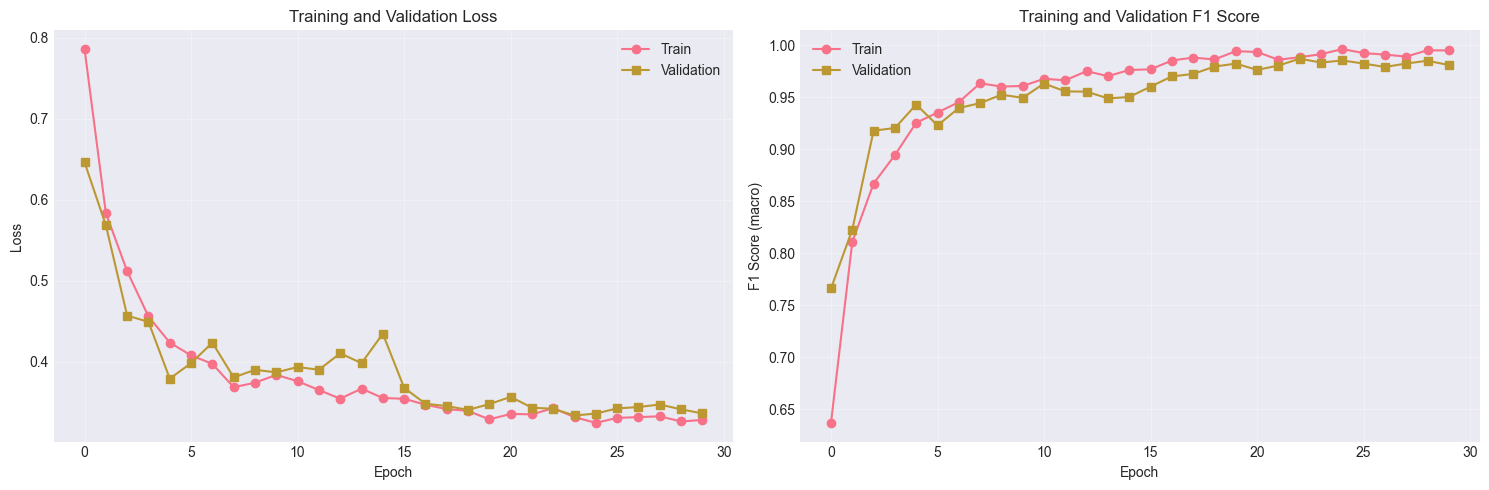

📈 Best validation F1 score: 0.9869


In [32]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history['train_loss'], label='Train', marker='o')
ax1.plot(history['val_loss'], label='Validation', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# F1 Score
ax2.plot(history['train_f1'], label='Train', marker='o')
ax2.plot(history['val_f1'], label='Validation', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score (macro)')
ax2.set_title('Training and Validation F1 Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'📈 Best validation F1 score: {best_f1:.4f}')

## 9. Evaluation

📊 Classification Report:

              precision    recall  f1-score   support

   high_pain     0.9870    0.9744    0.9806        78
    low_pain     0.9706    1.0000    0.9851       132
     no_pain     0.9972    0.9930    0.9951       716

    accuracy                         0.9924       926
   macro avg     0.9849    0.9891    0.9869       926
weighted avg     0.9925    0.9924    0.9925       926



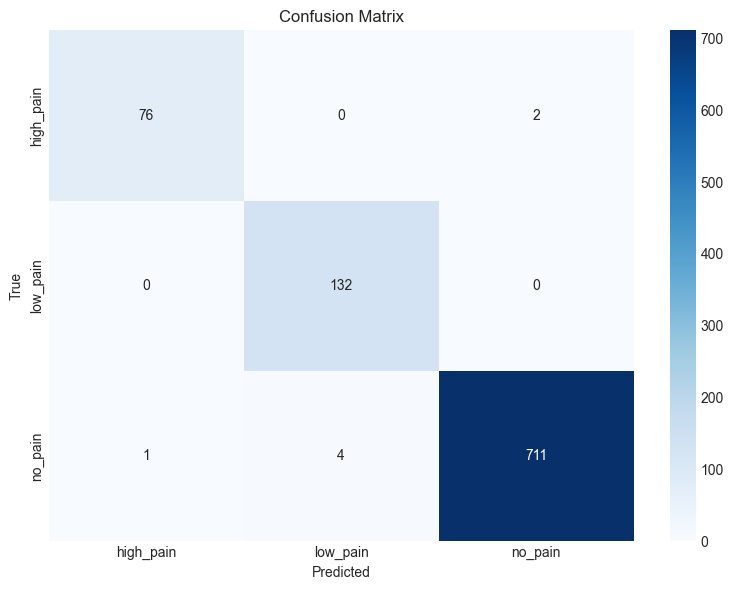

In [33]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_model_pytorch.pth'))
_, _, val_preds, val_labels = eval_epoch(model, val_loader, criterion, device)

# Classification report
print('📊 Classification Report:\n')
print(classification_report(
    val_labels, val_preds, 
    target_names=label_encoder.classes_,
    digits=4
))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

## 10. Test Set Prediction e Submission

In [34]:
# Load test data
X_test = pd.read_csv('pirate_pain_test.csv')

print(f'📊 Test Data:')
print(f'   Shape: {X_test.shape}')
print(f'   Samples: {X_test["sample_index"].nunique()}')
print(f'   Timesteps/sample: {X_test.groupby("sample_index").size().iloc[0]}')

📊 Test Data:
   Shape: (211840, 40)
   Samples: 1324
   Timesteps/sample: 160


In [35]:
# Apply same preprocessing to test
X_test_proc = X_test.copy()

# ADVICE 07/11: Map categorical
for col, mapping in cat_map.items():
    X_test_proc[col] = X_test_proc[col].map(mapping).fillna(0).astype(int)

# ADVICE 12/11: Add time features
max_time_test = X_test_proc['time'].max()
X_test_proc['time_sin'] = np.sin(2*np.pi*X_test_proc['time']/max_time_test)
X_test_proc['time_cos'] = np.cos(2*np.pi*X_test_proc['time']/max_time_test)
X_test_proc['time_norm'] = X_test_proc['time']/max_time_test

print('✅ Test preprocessing done')

✅ Test preprocessing done


In [36]:
# Create windows for test and predict
print('🔄 Creating test windows and predicting...')

test_sample_indices = X_test['sample_index'].unique()
sample_predictions = {}  # Store predictions per sample

model.eval()
with torch.no_grad():
    for sid in tqdm(test_sample_indices, desc='Predicting'):
        # Create windows for this sample
        windows = create_windows(X_test_proc, sid, WINDOW_SIZE, WINDOW_STRIDE)
        
        if len(windows) > 0:
            # Convert to array and normalize
            X_sample = np.array(windows, dtype=np.float32)
            X_sample = scaler.transform(
                X_sample.reshape(-1, X_sample.shape[-1])
            ).reshape(X_sample.shape)
            
            # Convert to tensor and predict
            X_tensor = torch.FloatTensor(X_sample).to(device)
            outputs = model(X_tensor)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            
            # Aggregate: average probabilities across windows, then argmax
            avg_probs = probs.mean(axis=0)
            pred_class = np.argmax(avg_probs)
            
            sample_predictions[sid] = pred_class

print(f'✅ Predicted {len(sample_predictions)} samples')

🔄 Creating test windows and predicting...


Predicting: 100%|██████████| 1324/1324 [00:09<00:00, 146.54it/s]

✅ Predicted 1324 samples


In [37]:
# Create submission DataFrame
submission_data = []
for sid in sorted(sample_predictions.keys()):
    pred_class = sample_predictions[sid]
    pred_label = label_encoder.classes_[pred_class]
    submission_data.append({
        'sample_index': sid,
        'label': pred_label
    })

submission = pd.DataFrame(submission_data)

# Save submission
submission.to_csv('submission_pytorch.csv', index=False)

print('✅ Submission created!')
print(f'   Shape: {submission.shape}')
print(f'   Columns: {list(submission.columns)}')
print(f'\n📊 Predicted label distribution:')
print(submission['label'].value_counts())
print(f'\n💾 Saved to: submission_pytorch.csv')
display(submission.head(10))

✅ Submission created!
   Shape: (1324, 2)
   Columns: ['sample_index', 'label']

📊 Predicted label distribution:
label
no_pain      1039
low_pain      189
high_pain      96
Name: count, dtype: int64

💾 Saved to: submission_pytorch.csv


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain
5,5,no_pain
6,6,no_pain
7,7,no_pain
8,8,no_pain
9,9,no_pain


## 11. F1 Score Analysis e Ottimizzazione

Analizziamo come massimizzare l'F1 macro score.

🎯 F1 Score Analysis on Validation Set



📊 Per-Class Metrics:

high_pain:
  Precision: 0.9870
  Recall:    0.9744
  F1 Score:  0.9806

low_pain:
  Precision: 0.9706
  Recall:    1.0000
  F1 Score:  0.9851

no_pain:
  Precision: 0.9972
  Recall:    0.9930
  F1 Score:  0.9951

🎯 Overall F1 Scores:
   F1 Macro (challenge metric):    0.9869
   F1 Weighted:                     0.9925


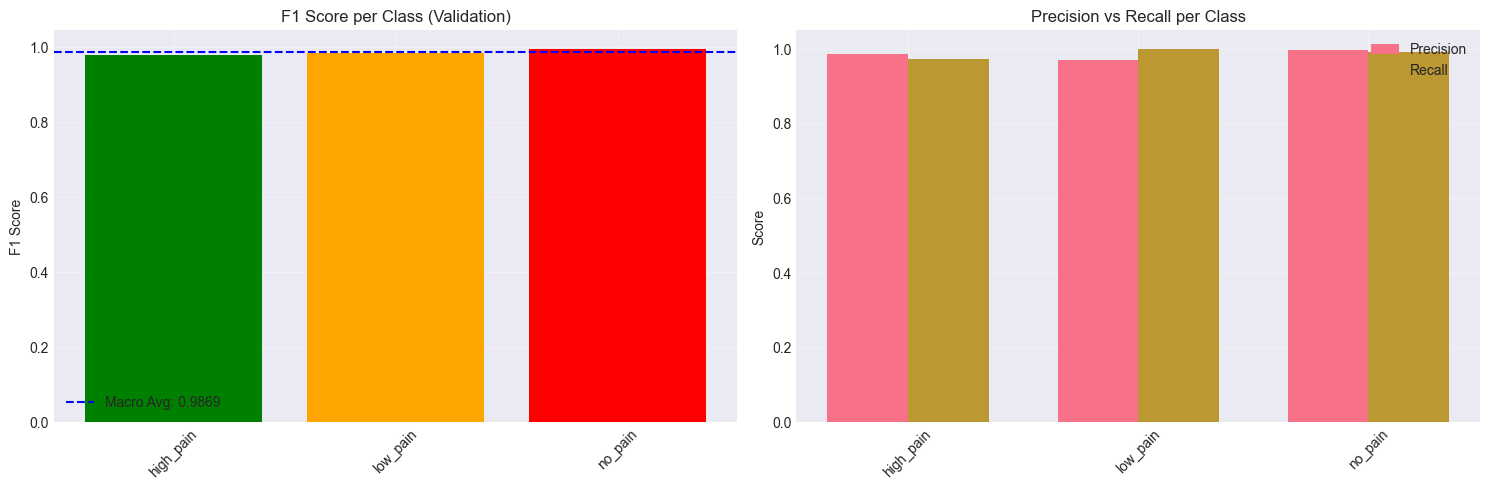

In [38]:
# Analyze F1 score per class
print('🎯 F1 Score Analysis on Validation Set\n')

# Get predictions
model.eval()
with torch.no_grad():
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    outputs = model(X_val_tensor)
    y_pred = outputs.argmax(1).cpu().numpy()

# Calculate per-class metrics
f1_per_class = f1_score(y_val, y_pred, average=None)
precision_per_class = precision_score(y_val, y_pred, average=None)
recall_per_class = recall_score(y_val, y_pred, average=None)

print('📊 Per-Class Metrics:\n')
for i, label_name in enumerate(label_encoder.classes_):
    print(f'{label_name}:')
    print(f'  Precision: {precision_per_class[i]:.4f}')
    print(f'  Recall:    {recall_per_class[i]:.4f}')
    print(f'  F1 Score:  {f1_per_class[i]:.4f}')
    print()

# Overall F1 scores
f1_macro = f1_score(y_val, y_pred, average='macro')
f1_weighted = f1_score(y_val, y_pred, average='weighted')

print(f'🎯 Overall F1 Scores:')
print(f'   F1 Macro (challenge metric):    {f1_macro:.4f}')
print(f'   F1 Weighted:                     {f1_weighted:.4f}')

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Per-class F1 scores
ax1 = axes[0]
x_pos = np.arange(len(label_encoder.classes_))
ax1.bar(x_pos, f1_per_class, color=['green', 'orange', 'red'])
ax1.set_xticks(x_pos)
ax1.set_xticklabels(label_encoder.classes_, rotation=45)
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Score per Class (Validation)')
ax1.axhline(y=f1_macro, color='blue', linestyle='--', label=f'Macro Avg: {f1_macro:.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision-Recall per class
ax2 = axes[1]
x_pos = np.arange(len(label_encoder.classes_))
width = 0.35
ax2.bar(x_pos - width/2, precision_per_class, width, label='Precision')
ax2.bar(x_pos + width/2, recall_per_class, width, label='Recall')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(label_encoder.classes_, rotation=45)
ax2.set_ylabel('Score')
ax2.set_title('Precision vs Recall per Class')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()